# Car Price prediction
## Прогнозирование стоимости автомобиля по характеристикам


In [ ]:
!pip install -q tensorflow==2.3

     |████████████████████████████████| 320.4 MB 47 kB/s 
     |████████████████████████████████| 2.9 MB 22.0 MB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
     |████████████████████████████████| 459 kB 51.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
#аугментации изображений
!pip install albumentations -q

     |████████████████████████████████| 631 kB 5.4 MB/s 


In [ ]:
!pip install pymorphy2
!pip install pymorphy2-dicts

     |████████████████████████████████| 55 kB 2.6 MB/s 
     |████████████████████████████████| 8.2 MB 6.0 MB/s 
     |████████████████████████████████| 7.1 MB 3.6 MB/s 


In [ ]:
pip install catboost

     |████████████████████████████████| 67.4 MB 52 kB/s 


In [ ]:


import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import pymorphy2
import collections
import seaborn as sns
from copy import copy

from sklearn.preprocessing import PolynomialFeatures
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6, 4)

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

In [ ]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.11 (default, Jul  3 2021, 18:01:19) 
Numpy        : 1.19.5
Tensorflow   : 2.3.0


In [ ]:
def product_age(x):
    if x > 2017: x = 1
    elif 2018 > x > 2015: x = 2
    elif 2016 > x > 2013: x = 3
    elif 2014 > x > 2004: x = 4
    elif 2005 > x: x = 5
    return x  
def mile_age(x):
    if x < 25000: x = 1
    elif 24999 < x < 50000: x = 2
    elif 49999 < x < 75000: x = 3
    elif 74999 < x < 100000: x = 4
    elif 99999 < x < 150000: x = 5
    elif 149999 < x < 200000: x = 6
    elif 199999 < x < 500000: x = 7
    elif 499999 < x: x = 8
    return x  
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\u261b"
        u"\u25cf" 
        u"\u2022" 
        u"\u2705"
        u"\u2611\ufe0f"
        u"\u27a5"
        u"\u2714\u000a"
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def mape(y_true, y_pred):
   return np.mean(np.abs((y_pred-y_true)/y_true))

In [ ]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
DATA_DIR = 'gdrive/My Drive/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [ ]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [ ]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

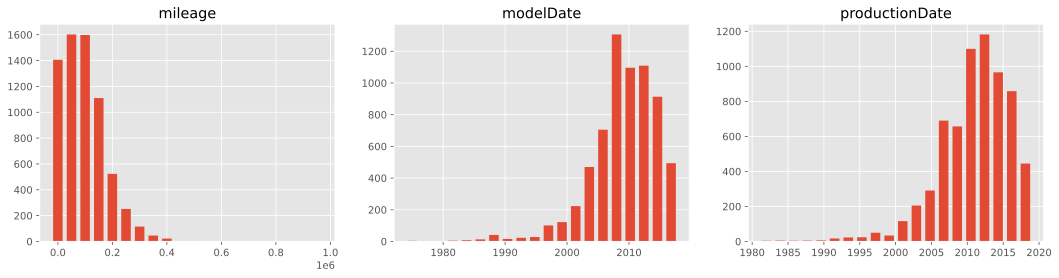

In [ ]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [ ]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'model_info', 'name',
  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate']

In [ ]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [ ]:
df = copy(data)

In [ ]:
data.isnull().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                5418
ПТС                        0
Привод                     0
Руль                       0
sample                     0
price                      0
dtype: int64

In [ ]:
data['Владение'].head()

0     6 лет и 3 месяца
1    6 лет и 6 месяцев
2                  NaN
3                  NaN
4                  NaN
Name: Владение, dtype: object

Столбец владение имеет очень много пропусков (большинство значений) и, видимо, является необязательным к заполнению на auto.ru, также он не несет какой-либо важной информации, так что его мы удалим.

In [ ]:
data.drop(['Владение'], axis = 1, inplace=True)

In [ ]:
data['Владельцы'].value_counts()

3 или более    3311
1 владелец     2526
2 владельца    2515
Name: Владельцы, dtype: int64

In [ ]:
col = collections.Counter(data['Владельцы'])
data['Владельцы'].fillna(col.most_common()[0][0], inplace=True)

In [ ]:
data.Владельцы = data.Владельцы.apply(lambda x: x[0])

In [ ]:
# работа с дубликатами, дубликатов нет
data.duplicated().value_counts()

False    8353
dtype: int64

In [ ]:
collections.Counter(data['engineDisplacement'])

Counter({'0.7 LTR': 6,
         '1.2 LTR': 33,
         '1.3 LTR': 32,
         '1.4 LTR': 106,
         '1.5 LTR': 73,
         '1.6 LTR': 410,
         '1.7 LTR': 15,
         '1.8 LTR': 411,
         '1.9 LTR': 5,
         '2.0 LTR': 2430,
         '2.1 LTR': 221,
         '2.2 LTR': 58,
         '2.3 LTR': 14,
         '2.4 LTR': 44,
         '2.5 LTR': 248,
         '2.6 LTR': 9,
         '2.7 LTR': 24,
         '2.8 LTR': 106,
         '2.9 LTR': 50,
         '3.0 LTR': 2349,
         '3.1 LTR': 44,
         '3.2 LTR': 60,
         '3.4 LTR': 4,
         '3.5 LTR': 250,
         '3.6 LTR': 23,
         '3.7 LTR': 14,
         '3.8 LTR': 3,
         '4.0 LTR': 153,
         '4.1 LTR': 23,
         '4.2 LTR': 103,
         '4.3 LTR': 4,
         '4.4 LTR': 329,
         '4.6 LTR': 5,
         '4.7 LTR': 137,
         '4.8 LTR': 57,
         '4.9 LTR': 2,
         '5.0 LTR': 74,
         '5.2 LTR': 13,
         '5.4 LTR': 33,
         '5.5 LTR': 268,
         '5.6 LTR': 3,
         

In [ ]:
data['engineDisplacement'] = data['engineDisplacement'].apply(
    lambda x: '2.0 LTR' if x == 'undefined LTR' else x)
data['engineDisplacement'] = data['engineDisplacement'].apply(
    lambda x: float((x.split(' ')[0])))

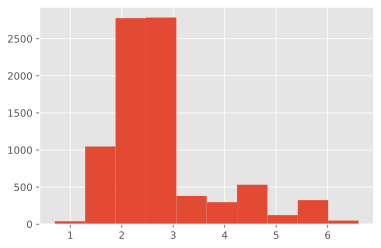

In [ ]:
data['engineDisplacement'].hist()

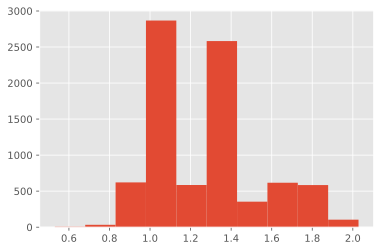

In [ ]:
#нормализуем данные
data['engineDisplacement'] = np.log(data['engineDisplacement'] + 1)
data['engineDisplacement'].hist()

In [ ]:
collections.Counter(data['enginePower'])

Counter({'100 N12': 1,
         '101 N12': 1,
         '102 N12': 22,
         '105 N12': 30,
         '109 N12': 5,
         '110 N12': 4,
         '113 N12': 3,
         '114 N12': 1,
         '115 N12': 62,
         '116 N12': 20,
         '118 N12': 4,
         '120 N12': 23,
         '122 N12': 95,
         '125 N12': 30,
         '129 N12': 9,
         '130 N12': 25,
         '132 N12': 1,
         '133 N12': 1,
         '136 N12': 200,
         '140 N12': 27,
         '143 N12': 28,
         '150 N12': 278,
         '156 N12': 223,
         '160 N12': 83,
         '163 N12': 63,
         '165 N12': 1,
         '166 N12': 1,
         '170 N12': 274,
         '174 N12': 1,
         '177 N12': 129,
         '180 N12': 145,
         '184 N12': 759,
         '190 N12': 420,
         '192 N12': 74,
         '193 N12': 19,
         '194 N12': 25,
         '197 N12': 46,
         '200 N12': 28,
         '204 N12': 174,
         '210 N12': 10,
         '211 N12': 310,
         '215 N12':

In [ ]:
data['enginePower'] = data['enginePower'].str.split().apply(lambda x: x[0]) 
data['enginePower'] = data['enginePower'].apply(lambda x: int(x))
data['enginePower'] /= 100

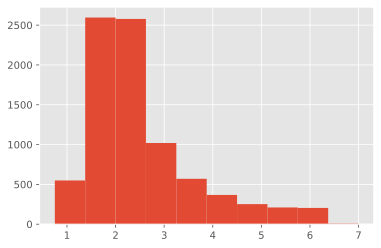

In [ ]:
data['enginePower'].hist()

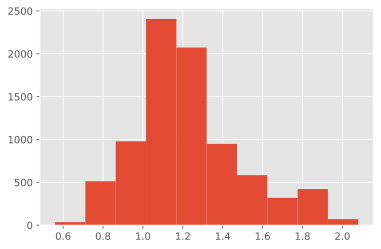

In [ ]:
#нормализуем данные
data['enginePower'] = np.log(data['enginePower'] + 1)
data['enginePower'].hist()

In [ ]:
#разобьем пробег по категориям и введем новый признак 
data['mileage_category'] = data['mileage'].map(mile_age)
data['mileage_category'].value_counts()

5    1962
6    1399
7    1246
4    1092
1     924
3     912
2     811
8       7
Name: mileage_category, dtype: int64

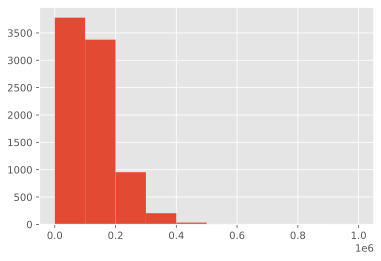

In [ ]:
data['mileage'].hist()

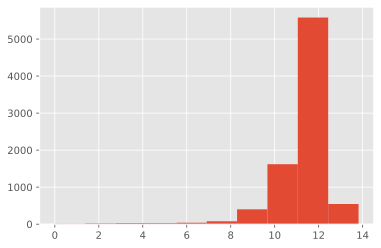

In [ ]:
#нормализуем данные
data['mileage'] = np.log(data['mileage'])
data['mileage'].hist()

In [ ]:
data['productionDate'].describe(), data['modelDate'].describe()

(count    8353.000000
 mean     2012.010775
 std         5.107314
 min      1982.000000
 25%      2009.000000
 50%      2013.000000
 75%      2016.000000
 max      2020.000000
 Name: productionDate, dtype: float64, count    8353.000000
 mean     2010.103556
 std         5.436914
 min      1971.000000
 25%      2007.000000
 50%      2011.000000
 75%      2014.000000
 max      2019.000000
 Name: modelDate, dtype: float64)

In [ ]:
#разобьем возраст автомобиля по категориям и введем новый признак
data['age_cat'] = data['productionDate'].map(product_age)

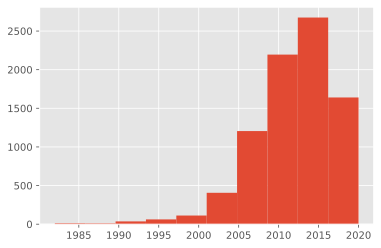

In [ ]:
data['productionDate'].hist()

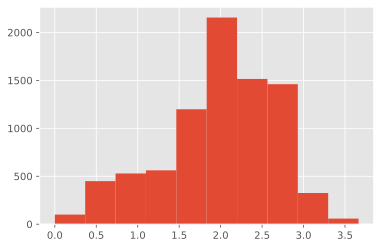

In [ ]:
data['productionDate'] = np.log(2021 - data['productionDate'])
data['productionDate'].hist()

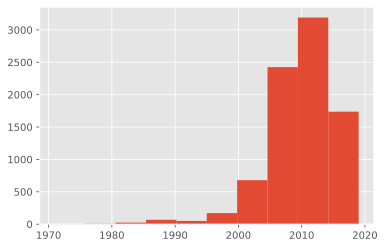

In [ ]:
data['modelDate'].hist()

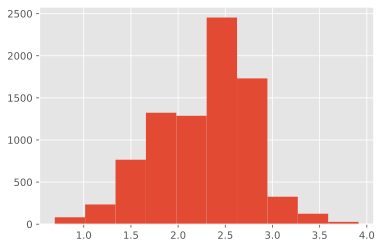

In [ ]:
data['modelDate'] = np.log(2021 - data['modelDate'])
data['modelDate'].hist()

In [ ]:
corr = data[['modelDate', 'productionDate']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,modelDate,productionDate
modelDate,1.000,0.938
productionDate,0.938,1.000


Мы видим серьёзную корерляцию между датой модели и датой производства, но оба признака оставим.


In [ ]:
data.name.head()

0                 300 3.0 AT (220 л.с.)
1    640d xDrive 3.0d AT (313 л.с.) 4WD
2           325xi 2.5 AT (218 л.с.) 4WD
3                318i 2.0 AT (136 л.с.)
4    520d xDrive 2.0d AT (190 л.с.) 4WD
Name: name, dtype: object

In [ ]:
#добавим новых признаков
data['4wd'] = data['name'].apply(lambda x: 1 if '4WD' in x else 0)
data['xdrive'] = data['name'].apply(lambda x: 1 if 'xDrive' in x else 0)
#удалим признак name как больше нам не нужный
data.drop(['name'], axis = 1, inplace=True)

In [ ]:
#также удалим признак vehicleConfiguration, так как он дублирует данные других признаков
data.drop(['vehicleConfiguration'], axis = 1, inplace=True)

In [ ]:
data.nunique()

bodyType                 17
brand                     3
color                    16
description            7654
engineDisplacement       47
enginePower             154
fuelType                  4
mileage                3507
modelDate                43
model_info              122
numberOfDoors             4
productionDate           39
sell_id                8353
vehicleTransmission       4
Владельцы                 3
ПТС                       2
Привод                    3
Руль                      2
sample                    2
price                  1629
mileage_category          8
age_cat                   5
4wd                       2
xdrive                    2
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             8353 non-null   object 
 1   brand                8353 non-null   object 
 2   color                8353 non-null   object 
 3   description          8353 non-null   object 
 4   engineDisplacement   8353 non-null   float64
 5   enginePower          8353 non-null   float64
 6   fuelType             8353 non-null   object 
 7   mileage              8353 non-null   float64
 8   modelDate            8353 non-null   float64
 9   model_info           8353 non-null   object 
 10  numberOfDoors        8353 non-null   int64  
 11  productionDate       8353 non-null   float64
 12  sell_id              8353 non-null   int64  
 13  vehicleTransmission  8353 non-null   object 
 14  Владельцы            8353 non-null   object 
 15  ПТС                  8353 non-null   o

In [ ]:
#обновляем список категориальных
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', '4wd', 'xdrive',
                        'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль',
                        'mileage_category', 'age_cat']

#обновляем список числовых признаков
numerical_features = ['mileage', 'modelDate', 'productionDate', 'enginePower', 'engineDisplacement']

In [ ]:
def preproc_data(df_input):
    df_output = df_input.copy()
    #обновляем список категориальных
    categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', '4wd', 'xdrive',
                        'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль',
                        'mileage_category', 'age_cat']
    #обновляем список числовых признаков
    numerical_features = ['mileage', 'modelDate', 'productionDate', 'enginePower', 'engineDisplacement']    

    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id',], axis = 1, inplace=True)
    col = collections.Counter(df_output['Владельцы'])
    df_output['Владельцы'].fillna(col.most_common()[0][0], inplace=True)
    df_output.Владельцы = df_output.Владельцы.apply(lambda x: x[0])
    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(
                                                      lambda x: '2.0 LTR' if x == 'undefined LTR' else x)
    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(
                                                      lambda x: float((x.split(' ')[0])))
    df_output['enginePower'] = df_output['enginePower'].str.split().apply(lambda x: x[0]) 
    df_output['enginePower'] = df_output['enginePower'].apply(lambda x: int(x))
    df_output['enginePower'] /= 100

    # ################### Feature Engineering ####################################################
    df_output['4wd'] = df_output['name'].apply(lambda x: 1 if '4WD' in x else 0)
    df_output['xdrive'] = df_output['name'].apply(lambda x: 1 if 'xDrive' in x else 0)
    df_output['age_cat'] = df_output['productionDate'].map(product_age)
    df_output['mileage_category'] = df_output['mileage'].map(mile_age)
    df_output['age_cat'] = df_output['productionDate'].map(product_age)

    # ################### Numerical Features ##############################################################
    # Обработаем числоые признаки, возьмем логарифм перед нормализацией
    df_output['enginePower'] = np.log(df_output['enginePower'] + 1)
    df_output['engineDisplacement'] = np.log(df_output['engineDisplacement'] + 1)
    df_output['modelDate'] = np.log(2021 - df_output['modelDate'])
    df_output['productionDate'] = np.log(2021 - df_output['productionDate'])
    df_output['mileage'] = np.log(df_output['mileage'])
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding:
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
    # One-Hot Encoding:
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
  
    
    # ################### Clean #################################################### 
    # убираем оставшиеся ненужные признаки признаки.
    df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    df_output.drop(['name'], axis = 1, inplace=True)
    df_output.drop(['Владение'], axis = 1, inplace=True)
    return df_output

In [ ]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(df)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,sample,price,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_0,...,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,mileage_category_0,mileage_category_1,mileage_category_2,mileage_category_3,mileage_category_4,mileage_category_5,mileage_category_6,mileage_category_7,age_cat_0,age_cat_1,age_cat_2,age_cat_3,age_cat_4
7399,0.379283,0.446603,0.838231,0.389193,0.489076,1,1590000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4273,0.379283,0.446603,0.775535,0.430677,0.439310,1,3100000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3362,0.895597,0.897888,0.790060,0.430677,0.489076,1,3750000.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2794,0.571389,0.446603,0.849485,0.500000,0.628510,1,1990000.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
5378,0.379283,0.392983,0.862198,0.430677,0.489076,1,1285000.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
5902,0.720397,0.873425,0.807309,0.467268,0.567601,1,3399999.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1454,0.571389,0.576032,0.787059,0.467268,0.489076,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2476,0.482220,0.392983,0.873217,0.604531,0.700125,1,700000.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
743,0.283725,0.135445,0.846530,0.604531,0.654526,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1168,0.895597,0.857278,0.759384,0.467268,0.531153,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 204 entries, engineDisplacement to age_cat_4
dtypes: float64(6), int64(1), uint8(197)
memory usage: 2.0 MB


## Split data

In [ ]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 203 entries, engineDisplacement to age_cat_4
dtypes: float64(6), uint8(197)
memory usage: 412.9 KB


# Model 2: CatBoostRegressor

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          learning_rate = 0.0546,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

0:	learn: 0.9611898	test: 0.9841469	best: 0.9841469 (0)	total: 50.3ms	remaining: 4m 11s
100:	learn: 0.2138954	test: 0.2083066	best: 0.2083066 (100)	total: 319ms	remaining: 15.5s
200:	learn: 0.1763333	test: 0.1733388	best: 0.1733388 (200)	total: 595ms	remaining: 14.2s
300:	learn: 0.1576314	test: 0.1565301	best: 0.1565301 (300)	total: 856ms	remaining: 13.4s
400:	learn: 0.1448988	test: 0.1466874	best: 0.1466874 (400)	total: 1.12s	remaining: 12.9s
500:	learn: 0.1377688	test: 0.1410769	best: 0.1410769 (500)	total: 1.4s	remaining: 12.6s
600:	learn: 0.1316540	test: 0.1365339	best: 0.1365106 (598)	total: 1.69s	remaining: 12.3s
700:	learn: 0.1254843	test: 0.1324700	best: 0.1324700 (700)	total: 1.95s	remaining: 12s
800:	learn: 0.1220685	test: 0.1308878	best: 0.1308787 (796)	total: 2.22s	remaining: 11.6s
900:	learn: 0.1182514	test: 0.1292765	best: 0.1292765 (900)	total: 2.49s	remaining: 11.3s
1000:	learn: 0.1143789	test: 0.1268209	best: 0.1268209 (1000)	total: 2.76s	remaining: 11s
1100:	learn: 0.

In [ ]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 11.79%



### Submission

In [ ]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [ ]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_0,brand_1,brand_2,...,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,mileage_category_0,mileage_category_1,mileage_category_2,mileage_category_3,mileage_category_4,mileage_category_5,mileage_category_6,mileage_category_7,age_cat_0,age_cat_1,age_cat_2,age_cat_3,age_cat_4
7320,0.945084,0.857278,0.862682,0.581508,0.628510,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
8037,0.379283,0.446603,0.720170,0.284662,0.299875,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4681,0.587878,0.465403,0.854462,0.664849,0.739185,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
6014,0.333212,0.318581,0.919752,0.625965,0.720353,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3649,0.571389,0.564974,0.850062,0.500000,0.567601,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0


## Simple Dense NN

In [ ]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               103936    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 235,521
Trainable params: 235,521
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

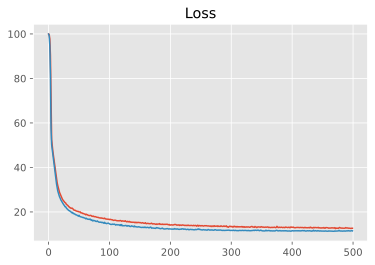

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('best_model.hdf5')
model.save('nn_1.hdf5')

In [ ]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.48%


In [ ]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Вывод: Были взяты логорифмы из числовых признаков. Обработнаы строковые признаки engineDisplacement, enginePower, из name взяла признак XDrive, 4wd. Обработанные ненужные признаки были удалены.

# Model 4: NLP + Multiple Inputs

In [ ]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [ ]:
# удалим из текста эмоджи
data.description = data.description.apply(lambda text: deEmojify(text))

In [ ]:
data.description

0       Всем привет!Продам эксклюзивный проект 124 уни...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. Третий...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.3-из Авто в се...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [ ]:
#проведем лемматизацию
morph = pymorphy2.MorphAnalyzer()
df_NLP = data.copy()

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]"


def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        tokens.append(token)
    return ' '.join(tokens)

In [ ]:
data['description'] = df_NLP.apply(
    lambda df_NLP: lemmatize(df_NLP.description), axis=1)

In [ ]:
data.description

0       весь привет продать эксклюзивный проект универ...
1       продавать любимый тачил обвес и тюнинг потому ...
2       машина тут продаваться не в первый раз но толь...
3       автомобиль в отличный состояние весь в родный ...
4       немка с бесключивый доступ и камера задний вид...
                              ...                        
8348    продаваться любимый автомобиль за год эксплуат...
8349    купить у официальный дилер в г третий владелец...
8350    торг на место всё работать сборка немецкий рез...
8351    автомобиль в отличный состояние из авто в семь...
8352    удлинённый заводский на база вообще то правиль...
Name: description, Length: 8353, dtype: object

In [ ]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [ ]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [ ]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.08 s, sys: 7.85 ms, total: 1.09 s
Wall time: 1.09 s


In [ ]:
tokenize.word_index

{'в': 1,
 'и': 2,
 'с': 3,
 'автомобиль': 4,
 'на': 5,
 'не': 6,
 'по': 7,
 'система': 8,
 'пробег': 9,
 'задний': 10,
 'всё': 11,
 'салон': 12,
 'сидение': 13,
 'год': 14,
 'состояние': 15,
 'для': 16,
 'передний': 17,
 'машина': 18,
 'от': 19,
 'до': 20,
 'при': 21,
 'у': 22,
 'комплект': 23,
 'диск': 24,
 'дилер': 25,
 'новый': 26,
 'без': 27,
 'ваш': 28,
 'вы': 29,
 'официальный': 30,
 'кредит': 31,
 'авто': 32,
 'быть': 33,
 'фара': 34,
 'руль': 35,
 'колесо': 36,
 'пакет': 37,
 'за': 38,
 'безопасность': 39,
 'гарантия': 40,
 'то': 41,
 'птс': 42,
 'комплектация': 43,
 'проверка': 44,
 'покупка': 45,
 'из': 46,
 'контроль': 47,
 'два': 48,
 'продажа': 49,
 'обмен': 50,
 'водитель': 51,
 'весь': 52,
 'полный': 53,
 'есть': 54,
 'зеркало': 55,
 'отличный': 56,
 'так': 57,
 'км': 58,
 'мы': 59,
 'условие': 60,
 'резина': 61,
 'только': 62,
 'шина': 63,
 'двигатель': 64,
 'пассажир': 65,
 'датчик': 66,
 'владелец': 67,
 'более': 68,
 'один': 69,
 'хороший': 70,
 'технический': 71,
 '

In [ ]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.08 s, sys: 23.2 ms, total: 1.1 s
Wall time: 1.09 s


In [ ]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

автомобиль проверить по пункт автокредит по специальный ставка от ауди центр север официальный дилер входящий в группа компания рольф и являться один из крупный дилер в европа предлагать вы ряд услуга по покупка и продажа автомобиль с пробег на протяжение многий год наш дилерский центр являться лидер по продажа автомобиль с пробег среди весь дилер в россия и предоставлять клиент самый большой выбор автомобиль с пробег и другой марка каждый автомобиль проходить тщательный диагностик и подготовка и гарантировать находиться в отличный состояние чтобы убедиться в правильный выбор у вы есть возможность пройти тест драйв ― ознакомительный поездка на интересовать автомобиль вы смочь ознакомиться с автомобиль не выходить из дом – наш менеджер провести презентация и в видеозвонок показать выбрать автомобиль также ауди центр север представлять уникальный предложение по кредитование автомобиль с пробег на индивидуальный условие специалист компания подобрать для вы хороший условие кредитование бол

### RNN NLP

In [ ]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [ ]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [ ]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     4919296     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 4s 295ms/step - loss: 99.9726 - MAPE: 99.9726 - val_loss: 99.6866 - val_MAPE: 99.6866
Epoch 2/500
12/12 [==============================] - 3s 238ms/step - loss: 97.4203 - MAPE: 97.4203 - val_loss: 88.6367 - val_MAPE: 88.6367
Epoch 3/500
12/12 [==============================] - 3s 237ms/step - loss: 68.8531 - MAPE: 68.8531 - val_loss: 53.7929 - val_MAPE: 53.7929
Epoch 4/500
12/12 [==============================] - 3s 252ms/step - loss: 52.8017 - MAPE: 52.8017 - val_loss: 46.5526 - val_MAPE: 46.5526
Epoch 5/500
12/12 [==============================] - 3s 237ms/step - loss: 45.8114 - MAPE: 45.8114 - val_loss: 41.6348 - val_MAPE: 41.6348
Epoch 6/500
12/12 [==============================] - 3s 239ms/step - loss: 40.3241 - MAPE: 40.3241 - val_loss: 36.7452 - val_MAPE: 36.7452
Epoch 7/500
12/12 [==============================] - 3s 239ms/step - loss: 35.6345 - MAPE: 35.6345 - val_loss: 31.5286 - val_MAPE: 31.5286
Epoch 8/500
12/12 [========

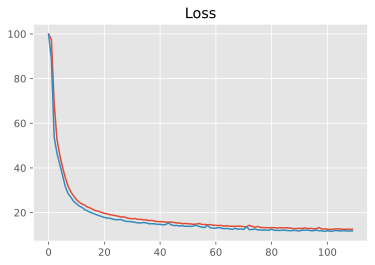

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('best_model.hdf5')
model.save('nn_mlp_nlp.hdf5')

In [ ]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.80%


In [ ]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Выводы: мы произвели лемматизацию, почистили текстовые данные, удалили не нужные символы, модель показала неплохой результат.

# Model 5: Добавляем картинки

### Data

In [ ]:
#import zipfile
#imgs = zipfile.ZipFile(DATA_DIR + 'img.zip', 'r')
#imgs.printdir()
#imgs.extractall(DATA_DIR+'/img')

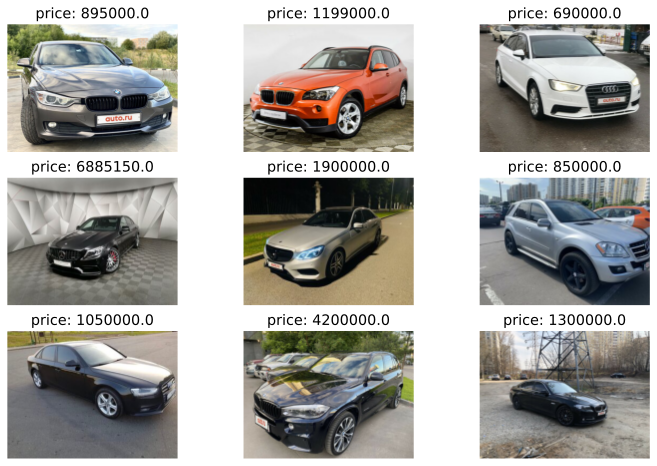

In [ ]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [ ]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

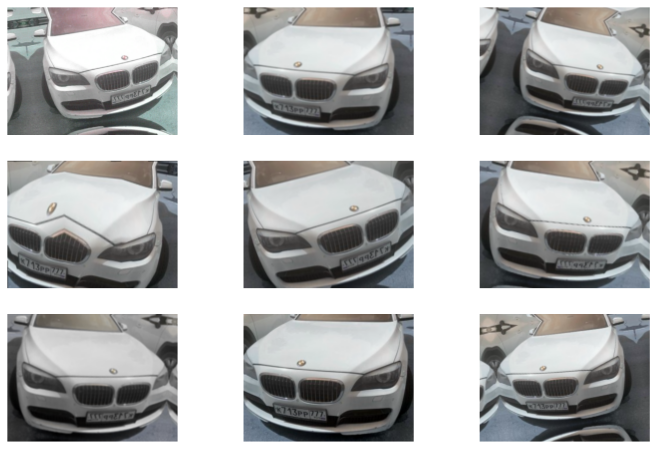

In [ ]:

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

'''
from albumentations import (
    RandomRotate90, Flip, Transpose, OneOf, IAAAdditiveGaussianNoise, GaussNoise, Compose,
    MotionBlur, MedianBlur, Blur, ShiftScaleRotate, OpticalDistortion, GridDistortion,
    IAAPiecewiseAffine, CLAHE, IAASharpen, IAAEmboss, RandomBrightnessContrast, HueSaturationValue
    )

augmentation = Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),            
        ], p=0.3),
        HueSaturationValue(p=0.3)
], p=1)
'''
#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

In [ ]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [ ]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [ ]:
#нормализация включена в состав модели EfficientNetB6, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB6(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

165240832/165234480 [==============================] - 7s 0us/step


In [ ]:
print("Number of layers in the base model: ", len(efficientnet_model.layers))

Number of layers in the base model:  666


In [ ]:
# Fine-tuning.
efficientnet_model.trainable = True

fine_tune_at = len(efficientnet_model.layers)//2

for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f22d3d2e790> True
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x7f22c0073ed0> True
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7f22d3d2a690> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f22d3d38310> True
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f225c9d84d0> True
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7f22d3d3aa50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f22d3e24f90> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f22d3d67710> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f22d3d227d0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f22d3e85cd0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f225d279cd0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f22d3e24dd0> True
<tensorflow.python.keras.layers.core.Dropout object at 0

In [ ]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [ ]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [ ]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 137s 722ms/step - loss: 50.3686 - MAPE: 50.3686 - val_loss: 26.8673 - val_MAPE: 26.8673
Epoch 2/100
190/190 [==============================] - 127s 670ms/step - loss: 24.9181 - MAPE: 24.9181 - val_loss: 22.3628 - val_MAPE: 22.3628
Epoch 3/100
190/190 [==============================] - 137s 719ms/step - loss: 21.9122 - MAPE: 21.9122 - val_loss: 19.8238 - val_MAPE: 19.8238
Epoch 4/100
190/190 [==============================] - 132s 696ms/step - loss: 19.8606 - MAPE: 19.8606 - val_loss: 18.6772 - val_MAPE: 18.6772
Epoch 5/100
190/190 [==============================] - 129s 681ms/step - loss: 18.7332 - MAPE: 18.7332 - val_loss: 17.7978 - val_MAPE: 17.7978
Epoch 6/100
190/190 [==============================] - 131s 687ms/step - loss: 17.9677 - MAPE: 17.9677 - val_loss: 15.9774 - val_MAPE: 15.9774
Epoch 7/100
190/190 [==============================] - 133s 699ms/step - loss: 17.2403 - MAPE: 17.2403 - val_loss: 16.7092 - val_MAPE: 16.7092

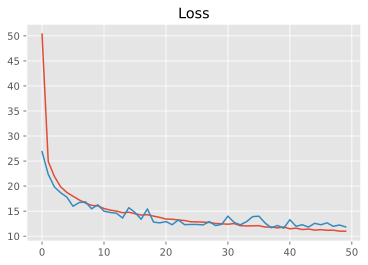

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('best_model.hdf5')
model.save('nn_final.hdf5')

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.85%


In [ ]:

sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

# Blend

In [ ]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.67%


In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [ ]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [ ]:
# FEATURE Input
# Iput
enginePower = L.Input(shape=[1], name="enginePower")
# Embeddings layers
emb_enginePower = L.Embedding(len(X.enginePower.unique().tolist())+1, 20)(enginePower)
f_enginePower = L.Flatten()(emb_enginePower)

In [ ]:
combinedInput = L.concatenate([model_mlp.output, f_enginePower,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, enginePower], outputs=head)

In [ ]:
model.summary()

Model: "functional_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_13_input (InputLayer)     [(None, 202)]        0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          103936      dense_13_input[0][0]             
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 512)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
enginePower (InputLayer)        [(None, 1)]          0                                            
______________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
history = model.fit([X_train, X_train.enginePower.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.enginePower.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 0s 17ms/step - loss: 97.0821 - MAPE: 97.0821 - val_loss: 87.3703 - val_MAPE: 87.3703
Epoch 2/500
12/12 [==============================] - 0s 7ms/step - loss: 64.4336 - MAPE: 64.4336 - val_loss: 34.2478 - val_MAPE: 34.2478
Epoch 3/500
12/12 [==============================] - 0s 7ms/step - loss: 37.6174 - MAPE: 37.6174 - val_loss: 28.7391 - val_MAPE: 28.7391
Epoch 4/500
12/12 [==============================] - 0s 7ms/step - loss: 28.0596 - MAPE: 28.0596 - val_loss: 20.9835 - val_MAPE: 20.9835
Epoch 5/500
12/12 [==============================] - 0s 7ms/step - loss: 22.4519 - MAPE: 22.4519 - val_loss: 18.1335 - val_MAPE: 18.1335
Epoch 6/500
12/12 [==============================] - 0s 7ms/step - loss: 20.1420 - MAPE: 20.1420 - val_loss: 16.8291 - val_MAPE: 16.8291
Epoch 7/500
12/12 [==============================] - 0s 8ms/step - loss: 18.9663 - MAPE: 18.9663 - val_loss: 16.4554 - val_MAPE: 16.4554
Epoch 8/500
12/12 [=====================

In [ ]:
model.load_weights('best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 12.23%
